In [1]:
import os 
import glob
import pickle
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from rdkit import Chem
from mordred import Calculator, descriptors
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error  
from sklearn.model_selection import GridSearchCV


## 這邊我們將前一輪的資料 假設是cycle_n 加上該輪所得到的新點 加上去 使其變成是cycle_n+1 的csv資料

In [2]:
yield_model_path = '/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/0_Create_Ground_Truth_Model/ground_truth_model/Ground_Truth_RandomForrest_Mordred.pkl'

with open(yield_model_path, 'rb') as f:
    rf_regressor = pickle.load(f)

In [3]:
# read in feature list

feature_df = pd.read_csv('/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/0_Create_Ground_Truth_Model/ground_truth_model/GT_feature_Mordred.csv')['features']
solvent_mordred = pd.read_csv('/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/0_Create_Ground_Truth_Model/data/solvent_mordred.csv')
base_mordred = pd.read_csv('/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/0_Create_Ground_Truth_Model/data/base_mordred.csv')

solvent_columns = list(set(feature_df).intersection(solvent_mordred))
solvent_columns.append('solvent_SMILES')
base_columns = list(set(feature_df).intersection(base_mordred))
base_columns.append('base_SMILES')

solvent_ft = solvent_mordred[solvent_columns]
base_ft = base_mordred[base_columns]

ligand_feature = []
for feature in feature_df:
    if 'ligand_' in feature:
        Mordred = feature.split('ligand_')[1]
        ligand_feature.append(Mordred)
        
feature_list = feature_df.tolist()
print(ligand_feature)
print(feature_list)
print(solvent_ft)
print(base_ft)

['PEOE_VSA10', 'AATS4dv', 'MATS1p', 'AATS6are', 'AATS5v', 'SlogP_VSA1', 'MINsssP', 'AATS6se', 'MATS1Z', 'GATS1are', 'MATS6v', 'MATS5d', 'AATSC5d', 'GATS1se', 'Xch-7d', 'MATS3i', 'MATS1dv', 'AATS5dv', 'AATS2are', 'MATS1m', 'MATS7i', 'GATS4dv', 'SsssP', 'AATS2se', 'MAXsssP', 'AATS1pe', 'GATS1pe', 'ETA_eta_FL', 'ATSC5dv', 'AATS5pe', 'SMR_VSA6', 'BCUTc-1l', 'AATSC1p', 'AXp-1dv', 'BCUTc-1h', 'EState_VSA7', 'AETA_eta_BR', 'AATS5Z', 'ATSC2c', 'AATSC1v']
['ligand_PEOE_VSA10', 'ligand_AATS4dv', 'ligand_MATS1p', 'ligand_AATS6are', 'ligand_AATS5v', 'ligand_SlogP_VSA1', 'ligand_MINsssP', 'ligand_AATS6se', 'ligand_MATS1Z', 'ligand_GATS1are', 'ligand_MATS6v', 'ligand_MATS5d', 'ligand_AATSC5d', 'ligand_GATS1se', 'ligand_Xch-7d', 'concentration', 'ligand_MATS3i', 'temperature', 'ligand_MATS1dv', 'ligand_AATS5dv', 'ligand_AATS2are', 'ligand_MATS1m', 'ligand_MATS7i', 'ligand_GATS4dv', 'ligand_SsssP', 'ligand_AATS2se', 'ligand_MAXsssP', 'ligand_AATS1pe', 'base_GATS1se', 'ligand_GATS1pe', 'ligand_ETA_eta_

In [4]:
# predict the GT values and add them to new dataframe

from sklearn.ensemble import RandomForestRegressor
import pickle

def aryl_yield_predict(df: pd.DataFrame, 
                        aryl_rfr: RandomForestRegressor, 
                        ):
    
    df_yield = df[feature_list]
    # df_score = df[pvk_score_feature_list]

    # return pvk_rfr.predict(df_size), pvk_rfc.predict(df_score), df[pvk_size_feature_list], df[pvk_score_feature_list]
    return aryl_rfr.predict(df_yield)


In [5]:
cycle_count = ['c2'] # 目前跑完的cycle 假設是第0個跑完 想要有地1個cycle的predictor 就設0 假設cycle1結束 就設1 這樣會做cycle1的predictor
#methods = ['ABC', 'GA', 'PSO', 'SA']
methods = ['ABC', 'PSO']
#methods = ['Random/round1', 'Random/round2', 'Random/round3', 'Random/round4', 'Random/round5','Random/round6','Random/round7', 'Random/round8', 'Random/round9', 'Random/round10']
#methods = ['Random/round1', 'Random/round2', 'Random/round3', 'Random/round4', 'Random/round5','Random/round6','Random/round7', 'Random/round8','Random/round10']
methods = ['BO/round1', 'BO/round2', 'BO/round3', 'BO/round4', 'BO/round5',
           'BO/round6', 'BO/round7', 'BO/round8', 'BO/round9', 'BO/round10']
finished_cycle = 2
pattern = r"\d{8}\w+_Report\.csv"
# pvk_size_feature_list = ['Reagent1 (ul)','Reagent2 (ul)','Reagent3 (ul)','Reagent4 (ul)','lab_code','AATS3i','ATSC5Z','AATSC5Z']
# pvk_size_feature_list = ['Reagent1 (ul)','Reagent2 (ul)','Reagent3 (ul)','Reagent4 (ul)','lab_code','ATSC5v', 'AATSC5Z', 'MATS8se']


parent_directory = '/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary'
preprocessing_for_analysis = os.path.join(parent_directory, '1_Preprocessing_for_Analysis')
make_new_data_predictor = os.path.join(parent_directory, '3_Make_New_Data_Predictor')

cyclen_list = ['Base_SMILES', 'Ligand_SMILES','Solvent_SMILES','Concentration','Temp_C','yield']

for method in methods:
    prediction_folder = os.path.join(preprocessing_for_analysis, method, cycle_count[-1])
    for filename in os.listdir(prediction_folder):
        if re.match(pattern, filename):
            # 如果檔案名稱符合條件，列印檔案的完整路徑
            file_path = os.path.join(prediction_folder, filename)
            print(file_path)
            pred_df = pd.read_csv(file_path)
            gt_value = aryl_yield_predict(pred_df, rf_regressor)
            pred_df.rename(columns={'concentration': 'Concentration',
                                    'temperature': 'Temp_C',
                                    'solvent_SMILES': 'Solvent_SMILES',
                                    'base_SMILES': 'Base_SMILES'},
                           inplace=True)
            pred_df['yield'] = gt_value
            pred_df = pred_df[cyclen_list]
            pred_df = pred_df.sort_values(by='yield', ascending=False)
            #pred_df = pred_df[:10]
            if len(cycle_count[0]) == 3:
                pred_df.to_csv(os.path.join(make_new_data_predictor, method, f'cycle{int(cycle_count[-1][2])+10}_pred.csv'), index=False)
                print('>10 csv saved')
                df_gt = pd.read_csv(os.path.join(make_new_data_predictor, method, f'cycle{int(cycle_count[-1][2])+10}.csv'))
                df_gt = pd.concat([df_gt, pred_df], axis=0)
                df_gt.to_csv(os.path.join(make_new_data_predictor,method, f'cycle{int(cycle_count[-1][2]) + 11}.csv'), index=False)
            else:
                pred_df.to_csv(os.path.join(make_new_data_predictor, method, f'cycle{int(cycle_count[-1][1])}_pred.csv'), index=False)
                print('csv saved')
                df_gt = pd.read_csv(os.path.join(make_new_data_predictor, method, f'cycle{int(cycle_count[-1][1])}.csv'))
                df_gt = pd.concat([df_gt, pred_df], axis=0)
                df_gt.to_csv(os.path.join(make_new_data_predictor,method, f'cycle{int(cycle_count[-1][1]) + 1}.csv'), index=False)

/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/1_Preprocessing_for_Analysis/BO/round1/c2/20250731aryl_Report.csv
csv saved
/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/1_Preprocessing_for_Analysis/BO/round2/c2/20250731aryl_Report.csv
csv saved
/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/1_Preprocessing_for_Analysis/BO/round3/c2/20250731aryl_Report.csv
csv saved
/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/1_Preprocessing_for_Analysis/BO/round4/c2/20250731aryl_Report.csv
csv saved
/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/1_Preprocessing_for_Analysis/BO/round5/c2/20250731aryl_Report.csv
csv saved
/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/1_Preprocessing_for_Analysis/BO/round6/c2/20250731aryl_Report.csv
csv saved
/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/1_Preprocessing_for_Analysis/BO/round7/c2/20250731aryl_Report.csv
csv saved
/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/1_Pr

# 製作新predictor

In [6]:
solvent_mordred = pd.read_csv('/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/0_Create_Ground_Truth_Model/data/solvent_mordred.csv')
base_mordred = pd.read_csv('/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/0_Create_Ground_Truth_Model/data/base_mordred.csv')

# prepare the expt + gt data befoe, read differenrt every time
# remeber to change the cycle number !!!!!!!!!!
# cyclen_data = pd.read_csv('/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/3_Make_New_Data_Predictor/PSO/cycle7.csv')

In [7]:
# get encoder info in X
import sys
sys.path.append('/home/ianlee/JTVAE/JTVAE/CPU-P3')
from fast_jtnn import *
from rdkit import Chem

# setting VAE params
VAE_path = "/home/ianlee/JTVAE/Ian_train/Train/MODEL-TRAIN-3/model.epoch-39"
vocab_path = "/home/ianlee/JTVAE/Ian_train/Vocabulary/smi_vocab-2.txt"

vocab_list = [x.strip("\r\n ") for x in open(vocab_path)]
vocab = Vocab(vocab_list)

hidden_size = 450
latent_size = 32
depthT = 20
depthG = 3

device = torch.device("cpu")
print(torch.cuda.device_count())

VAE = JTNNVAE(vocab, hidden_size, latent_size, depthT, depthG)
VAE.load_state_dict(torch.load(VAE_path,map_location=(device)))
VAE.cpu()
VAE.eval()

X = {}
Y = {}

for method in methods:
    #obtain SMILES and latent vector
    cyclen_data = pd.DataFrame(pd.read_csv(os.path.join(make_new_data_predictor, f'{method}/cycle{finished_cycle+1}.csv')))
    # 使用 'Base_SMILES'、'Ligand_SMILES' 和 'Solvent_SMILES' 作為合併的鍵, ligand_mordred不會用到
    merged_data = pd.merge(cyclen_data, base_mordred, left_on='Base_SMILES', right_on='base_SMILES', how='left')
    merged_data = pd.merge(merged_data, solvent_mordred, left_on='Solvent_SMILES', right_on='solvent_SMILES', how='left')

    # 刪除原始的 'Base_SMILES' 和 'Solvent_SMILES' 和 'yield' 列
    merged_data = merged_data.drop(columns=['Base_SMILES', 'Solvent_SMILES','base_SMILES', 'solvent_SMILES','Unnamed: 0', 'yield'])

    # 顯示合併後的資料
    #print(merged_data.shape)
    #print(merged_data.columns)
    
    data_smi = list(merged_data['Ligand_SMILES'])
        
    #print(data_smi)

    latent = VAE.encode_latent_mean(data_smi)
    latent = latent.detach().cpu().numpy() #latent is a huge numpy array which need to be concat with features

    # 刪除ligand smiles
    merged_data = merged_data.drop(columns=['Ligand_SMILES'])

    # We need to assume that we do not know anything about the solvent and base -- cannot filter the feautres
    # X_train = np.concatenate((latent, merged_data[predictor_feature['Feature']]), axis=1)
    X[method] = np.concatenate((latent, merged_data), axis=1)
    print(X[method].shape)
    Y[method] = cyclen_data['yield']
    # total = merged_data[predictor_feature['Feature'].tolist() + ['yield']]
    # total.to_csv('total.csv')

[09:01:15] WARNING: not removing hydrogen atom without neighbors


0
(40, 2246)
(40, 2246)
(40, 2246)
(40, 2246)
(40, 2246)
(40, 2246)
(40, 2246)
(40, 2246)
(40, 2246)
(40, 2246)


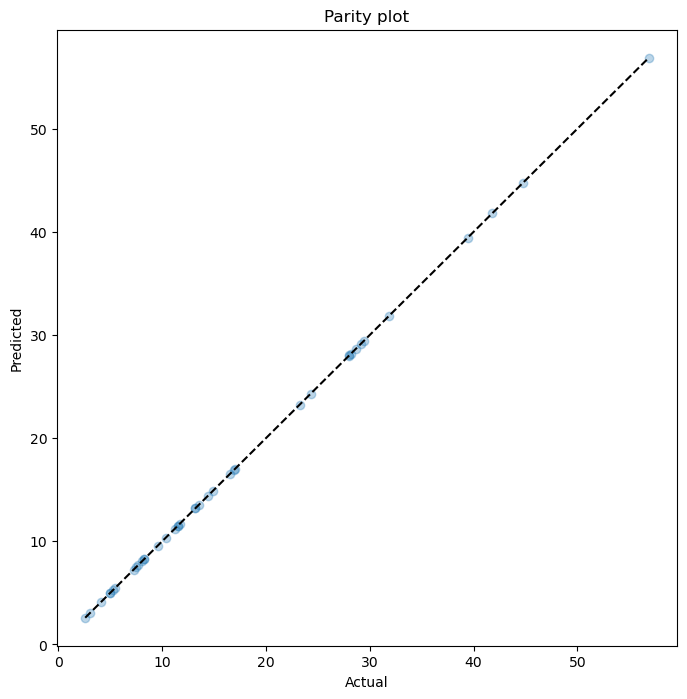

MSE between Train and Prediction:  2.2636257007937692e-07
Mean of Training Data y:  17.4147875
Std Dev of Training Data y:  12.74222423286428
cross validation r2 scores:  [ -1.25722831 -38.56293652  -0.1858354   -0.47800201  -4.42689308]
mean cross validation r2 scores:  -8.98217906476585


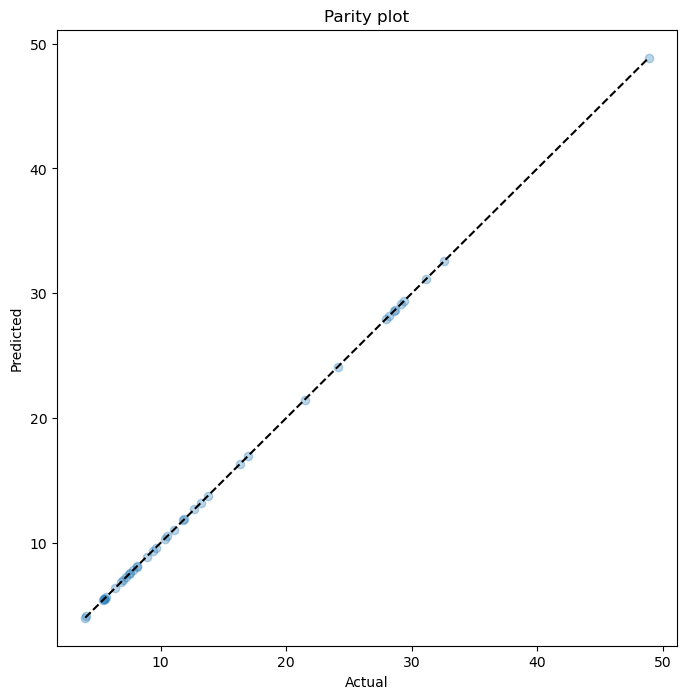

MSE between Train and Prediction:  1.34628988531844e-07
Mean of Training Data y:  14.713365
Std Dev of Training Data y:  10.442569434017422
cross validation r2 scores:  [ -1.27681565  -0.91532521  -0.23215131  -1.38930212 -23.34787334]
mean cross validation r2 scores:  -5.432293527237373


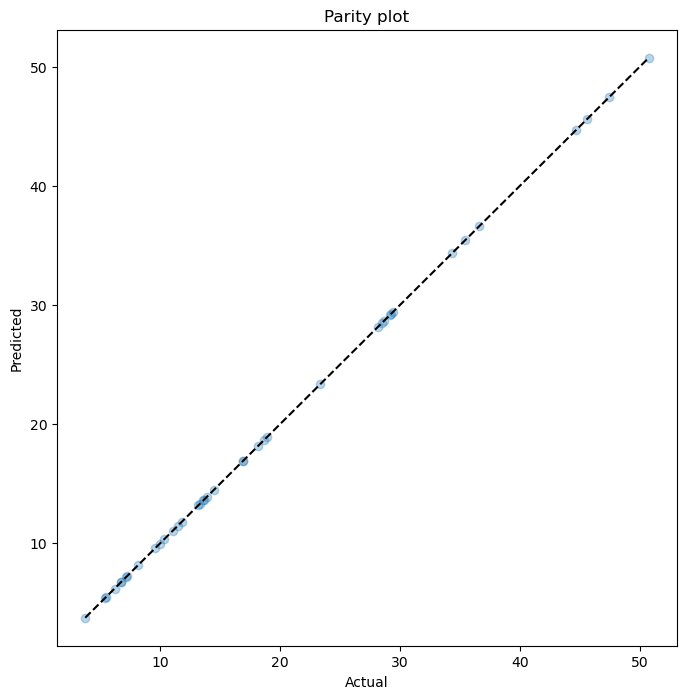

MSE between Train and Prediction:  2.571623626999133e-07
Mean of Training Data y:  19.5984925
Std Dev of Training Data y:  12.888104312706107
cross validation r2 scores:  [-0.76138764 -0.27895615  0.07579638 -0.28790512 -4.67082733]
mean cross validation r2 scores:  -1.1846559711707738


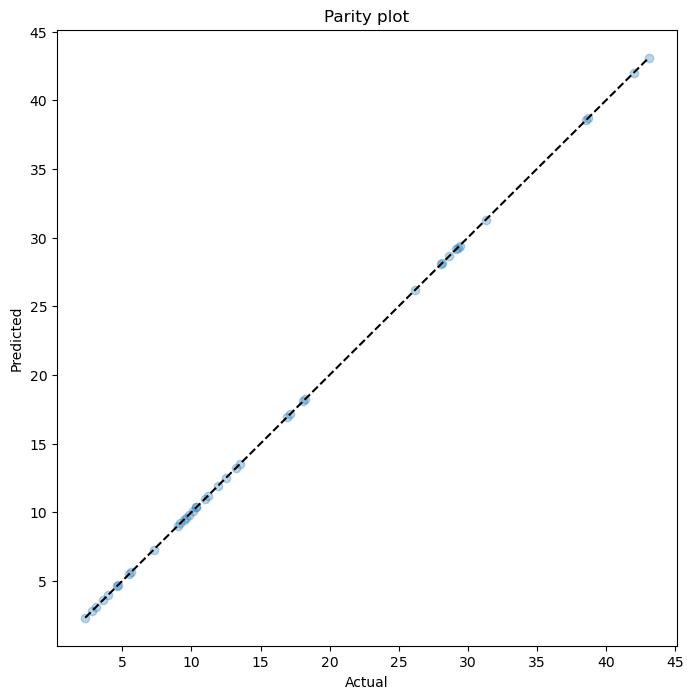

MSE between Train and Prediction:  1.1251110915700209e-07
Mean of Training Data y:  16.436825
Std Dev of Training Data y:  11.77551230158905
cross validation r2 scores:  [-2.22320771 -0.24183319  0.55538637  0.65184214 -9.37553883]
mean cross validation r2 scores:  -2.126670243134024


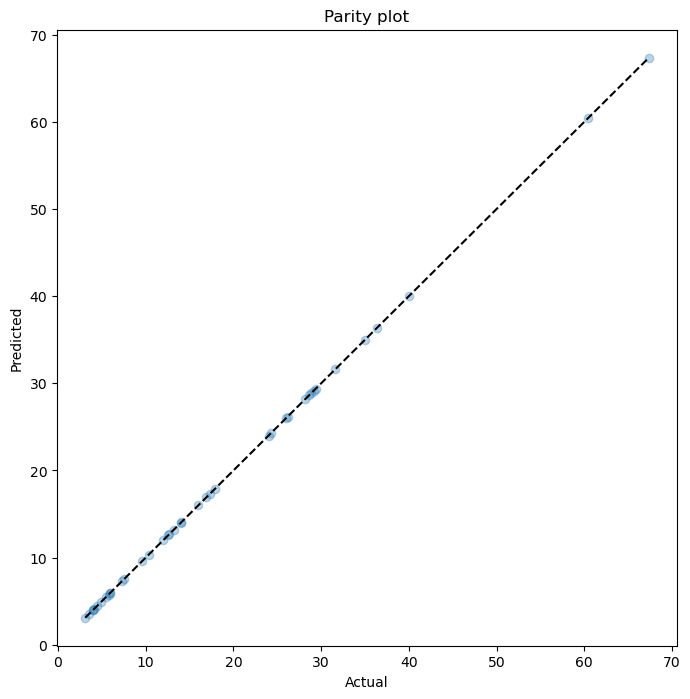

MSE between Train and Prediction:  1.9587744333426713e-05
Mean of Training Data y:  18.694862500000006
Std Dev of Training Data y:  14.82247686462502
cross validation r2 scores:  [ 0.25366648 -0.92358742 -0.11877442 -0.53858684 -1.57150286]
mean cross validation r2 scores:  -0.5797570126263519


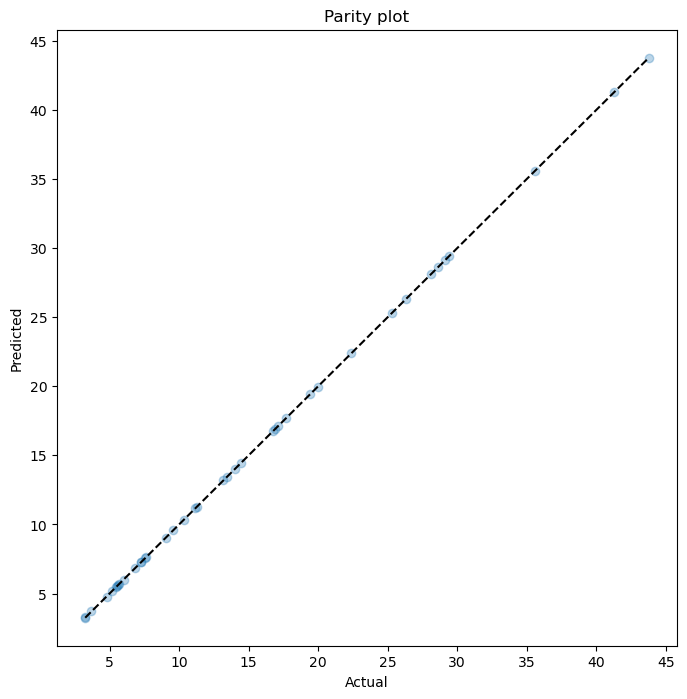

MSE between Train and Prediction:  2.7237478893820106e-07
Mean of Training Data y:  15.232604999999998
Std Dev of Training Data y:  10.629388773747763
cross validation r2 scores:  [ -1.19268995  -0.44896481  -0.59978328  -0.8108531  -12.18741608]
mean cross validation r2 scores:  -3.0479414418747814


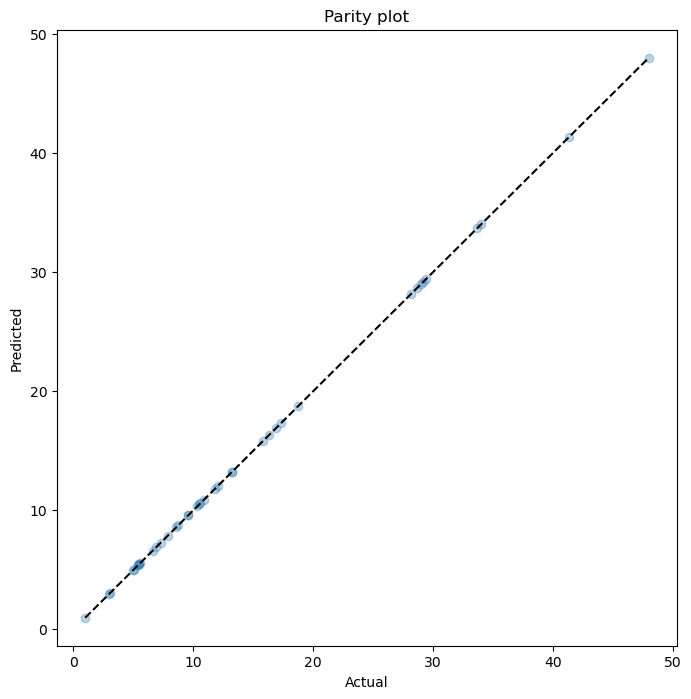

MSE between Train and Prediction:  4.458500377754509e-05
Mean of Training Data y:  14.7153275
Std Dev of Training Data y:  11.300124667519992
cross validation r2 scores:  [-1.66991694 -1.59180936 -0.24088856 -0.0920363  -4.82289252]
mean cross validation r2 scores:  -1.6835087349754176


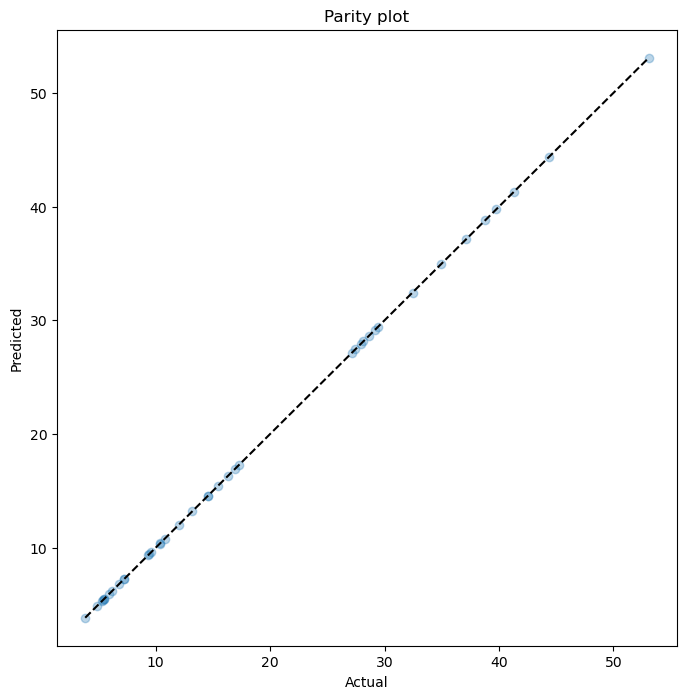

MSE between Train and Prediction:  1.5400975726976806e-07
Mean of Training Data y:  19.094389999999997
Std Dev of Training Data y:  13.28471013431983
cross validation r2 scores:  [-2.27471904  0.3786441   0.60557749  0.05788907 -4.12969219]
mean cross validation r2 scores:  -1.0724601170585752


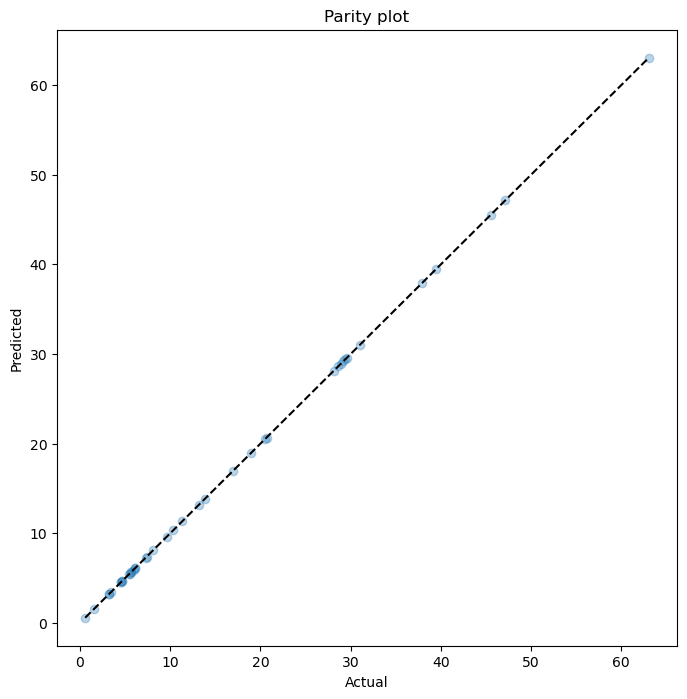

MSE between Train and Prediction:  1.2572090808137732e-07
Mean of Training Data y:  16.67341
Std Dev of Training Data y:  14.880844888661395
cross validation r2 scores:  [-0.60158693 -0.46252575 -0.56690011 -0.00948571 -0.64689645]
mean cross validation r2 scores:  -0.4574789893539613


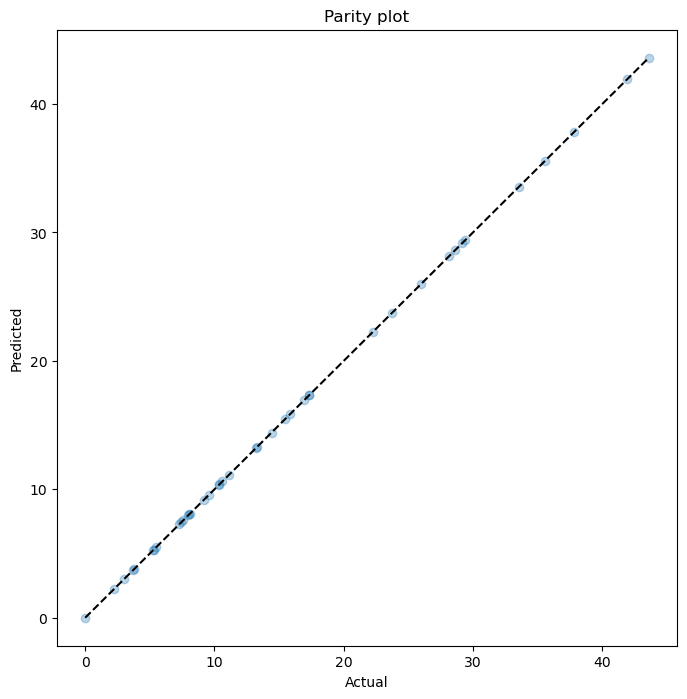

MSE between Train and Prediction:  2.0039255467467456e-07
Mean of Training Data y:  16.0010925
Std Dev of Training Data y:  11.56804346204205
cross validation r2 scores:  [-0.62360462 -0.68354679  0.16947329 -0.70044804 -0.52524316]
mean cross validation r2 scores:  -0.47267386476019874


In [8]:
from sklearn.model_selection import cross_val_score

for method in methods:
    # assign the new folder here
    xgb_folder = os.path.join(make_new_data_predictor, f'{method}/cycle{finished_cycle+1}')

    parameters = {
        'n_estimators': [90, 100, 110],
        'max_depth': [5, 6, 7],
        'learning_rate': [0.2, 0.3, 0.4],
        'subsample': [0.8, 0.9, 1.0],  

    }

    model = XGBRegressor()
    grid_search = GridSearchCV(model, parameters, cv=5)
    grid_search.fit(X[method], Y[method])
    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X[method])
    mse = mean_squared_error(Y[method], y_pred)
    mean = np.mean(Y[method])  
    std = np.std(Y[method])

    r2_scores = cross_val_score(model, X[method], y_pred, cv=5, scoring='r2')

    plt.figure(figsize=(8, 8))
    plt.scatter(Y[method], y_pred, alpha=0.3)
    plt.plot([Y[method].min(), Y[method].max()], [Y[method].min(), Y[method].max()], 'k--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Parity plot')
    plt.show()

    print("MSE between Train and Prediction: ", mse)
    print("Mean of Training Data y: ", mean)
    print("Std Dev of Training Data y: ", std)
    print("cross validation r2 scores: ", r2_scores)
    print("mean cross validation r2 scores: ", np.mean(r2_scores))
    results = pd.DataFrame(grid_search.cv_results_)
    results.to_csv('opt_result.csv')
    results = results.sort_values("mean_test_score", ascending=False)
    results = results[["mean_test_score", "params"]]
    results = results[:10]

    count = 0

    for i, row in results.iterrows():
        # 取得超參組合
        hyp = row[1]

        # 訓練模型
        xgb = XGBRegressor(**hyp)
        xgb.fit(X[method], Y[method])

        # 儲存模型
        with open(os.path.join(xgb_folder,f"ary_yield_xgboost{count}_c{int(cycle_count[-1][1])}.pkl"), "wb") as f:
            pickle.dump(xgb, f)
        count += 1

In [9]:
results

,mean_test_score,params
50,-0.426793,"{'learning_rate': 0.3, 'max_depth': 7, 'n_esti..."
53,-0.426793,"{'learning_rate': 0.3, 'max_depth': 7, 'n_esti..."
47,-0.426793,"{'learning_rate': 0.3, 'max_depth': 7, 'n_esti..."
18,-0.447948,"{'learning_rate': 0.2, 'max_depth': 7, 'n_esti..."
21,-0.448116,"{'learning_rate': 0.2, 'max_depth': 7, 'n_esti..."
24,-0.448217,"{'learning_rate': 0.2, 'max_depth': 7, 'n_esti..."
9,-0.460703,"{'learning_rate': 0.2, 'max_depth': 6, 'n_esti..."
12,-0.460882,"{'learning_rate': 0.2, 'max_depth': 6, 'n_esti..."
15,-0.460984,"{'learning_rate': 0.2, 'max_depth': 6, 'n_esti..."
38,-0.472719,"{'learning_rate': 0.3, 'max_depth': 6, 'n_esti..."
